# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
#connectDrive()

# Change path
#changeDirectory("/content/drive/MyDrive/數位課程_檔案/Data Mining")

# Import Libraries

In [2]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb



In [3]:
import tensorflow as tf

In [4]:
'''TensorFlow and Keras'''

from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

## Check library versions & set seed

In [5]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.3.2
tensorflow 2.3.1
keras      2.4.0
numpy      1.20.0


In [6]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF, if GPU is available.")

Default GPU Device: /device:GPU:0


# Data Preparation 

## Load the data

In [8]:
current_path = os.getcwd()
file = os.path.sep.join(['/..', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [9]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [10]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

## Split into train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

## Scale the data

In [12]:
# Suppress warnings
#pd.set_option('mode.chained_assignment', None)

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [13]:
X_train_AE, X_test_AE = X_train.copy(), X_test.copy()

In [14]:
X_train_AE

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
142087,-1.008613,1.168013,0.203077,-0.252933,-0.387030,-0.051340,-0.191393,0.917626,-0.220348,0.379391,...,0.240351,-0.230649,-0.781406,0.154163,-0.584578,-0.161870,0.232116,0.525621,0.459397,-0.301324
165168,0.071848,0.664025,-0.240845,-0.381091,0.694608,-0.633906,0.833474,-0.132701,-0.166967,-0.793682,...,0.099453,-0.438520,-1.037593,0.145573,1.078771,-0.761303,0.221753,0.564899,0.254973,-0.342346
235908,0.099163,-0.387383,-0.945009,-1.493663,-0.092322,-0.878326,1.252531,-0.564372,-2.760963,0.979945,...,0.136822,0.597949,2.047828,0.533608,1.885871,-0.949325,0.195840,0.394576,0.789716,0.507010
148255,0.015486,0.519611,0.193472,-0.418969,0.316777,-0.774851,0.816615,-0.154107,-0.060485,-0.393037,...,-0.038190,-0.336778,-0.738483,0.127711,-0.026519,-0.955999,0.297594,0.620507,0.285961,-0.333753
145672,0.009053,0.524138,0.175338,-0.335413,0.761346,0.501074,0.266188,0.187765,-0.186259,-0.837330,...,0.109213,-0.199423,-0.454902,0.047231,-0.725277,-2.181428,-0.147735,0.586351,0.739459,-0.337806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30023,-0.248756,0.101848,0.912701,-0.689923,-0.390323,-0.967547,0.402081,-0.288361,-1.323265,0.191669,...,0.116612,0.357935,1.207027,-0.068708,1.626206,0.627179,-0.301555,-0.111565,0.055604,-0.244532
195475,-0.253335,-2.746246,-2.084782,0.720012,-0.769996,0.041544,1.339133,-0.301589,0.282584,-0.212455,...,3.179094,1.344009,-0.220951,-1.818501,0.611705,-0.864687,1.299470,-0.906495,0.441942,5.075487
48687,0.105597,-1.126101,-0.469737,0.155903,-0.553633,-0.377108,0.650257,-0.276354,0.205489,-0.434196,...,1.502447,0.093703,-1.582795,-0.824693,-0.618596,0.108597,1.737300,-0.504121,0.291066,2.070088
159608,0.055428,0.496261,-0.097696,-0.583987,0.642842,-0.394402,0.805688,-0.112087,0.031969,-0.380252,...,0.003434,-0.436778,-1.056389,-0.076525,-1.668783,-0.672395,0.422070,0.604264,0.255831,-0.325281


## Define evaluation function and plotting function

In [15]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [16]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

# Model One 
## Two layer complete autoencoder with linear activation

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

In [18]:
# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# The linear activation function, also known as "no activation," or "identity function"
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [20]:
# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Epoch 1/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0823 - accuracy: 0.8946 - val_loss: 0.0011 - val_accuracy: 0.9836
Epoch 2/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0010 - accuracy: 0.9922 - val_loss: 5.0106e-06 - val_accuracy: 0.9990
Epoch 3/10
5964/5964 [==============================] - 19s 3ms/step - loss: 6.4649e-04 - accuracy: 0.9930 - val_loss: 3.0691e-04 - val_accuracy: 0.9937
Epoch 4/10
5964/5964 [==============================] - 18s 3ms/step - loss: 5.3280e-04 - accuracy: 0.9943 - val_loss: 8.5137e-06 - val_accuracy: 0.9988
Epoch 5/10
5964/5964 [==============================] - 18s 3ms/step - loss: 6.5626e-04 - accuracy: 0.9932 - val_loss: 6.6694e-05 - val_accuracy: 0.9966
Epoch 6/10
5964/5964 [==============================] - 18s 3ms/step - loss: 5.2073e-04 - accuracy: 0.9944 - val_loss: 5.9120e-04 - val_accuracy: 0.9883
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.6885e-04 - accu

## Evaluate on Test Set

2938/2938 [==============================] - 2s 723us/step


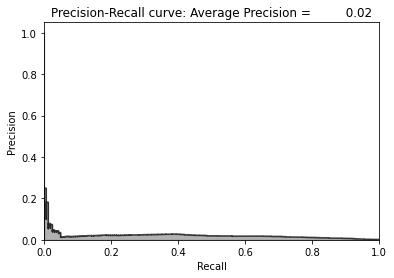

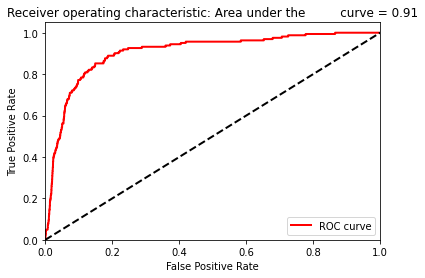

In [21]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1018 - accuracy: 0.8694 - val_loss: 0.0019 - val_accuracy: 0.9778
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0010 - accuracy: 0.9920 - val_loss: 1.5908e-06 - val_accuracy: 0.9993
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 7.7010e-04 - accuracy: 0.9929 - val_loss: 4.2303e-04 - val_accuracy: 0.9930
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.5560e-04 - accuracy: 0.9946 - val_loss: 2.3430e-06 - val_accuracy: 0.9994
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 7.0923e-04 - accuracy: 0.9937 - val_loss: 1.6159e-04 - val_accuracy: 0.9947
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.9952e-04 - accuracy: 0.9939 - val_loss: 8.6358e-04 - val_accuracy: 0.9848
Epoch 7/10
5964/5964 [==============================] - 18s 3ms/step - loss: 5.0587e-04 - accu

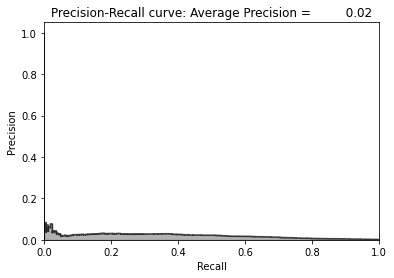

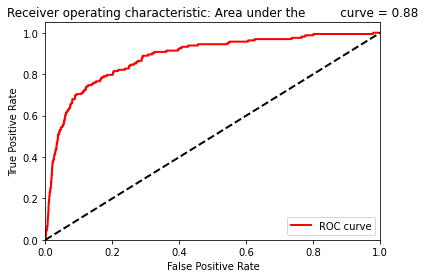

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0820 - accuracy: 0.8918 - val_loss: 0.0017 - val_accuracy: 0.9748
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 9.2651e-04 - accuracy: 0.9921 - val_loss: 7.5871e-05 - val_accuracy: 0.9967
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 7.1218e-04 - accuracy: 0.9939 - val_loss: 5.3380e-04 - val_accuracy: 0.9924
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.6629e-04 - accuracy: 0.9942 - val_loss: 8.3753e-07 - val_accuracy: 0.9996
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.5981e-04 - accuracy: 0.9943 - val_loss: 1.8316e-04 - val_accuracy: 0.9933
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.3979e-04 - accuracy: 0.9944 - val_loss: 8.3669e-04 - val_accuracy: 0.9873
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 4.6695e-04 - 

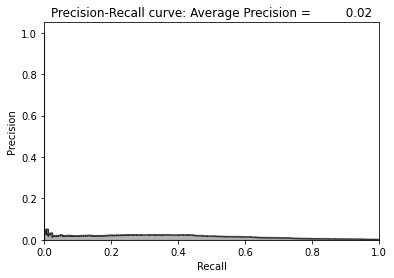

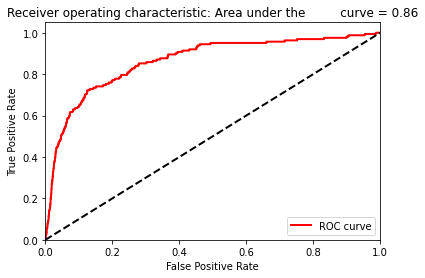

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0821 - accuracy: 0.9004 - val_loss: 0.0022 - val_accuracy: 0.9832
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0024 - accuracy: 0.9854 - val_loss: 4.4973e-04 - val_accuracy: 0.9929
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 7.1034e-04 - accuracy: 0.9924 - val_loss: 8.7131e-04 - val_accuracy: 0.9934
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.1945e-04 - accuracy: 0.9939 - val_loss: 4.0329e-06 - val_accuracy: 0.9993
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.6654e-04 - accuracy: 0.9933 - val_loss: 9.8609e-05 - val_accuracy: 0.9961
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.5121e-04 - accuracy: 0.9941 - val_loss: 8.4076e-04 - val_accuracy: 0.9868
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.1473e-04 - accu

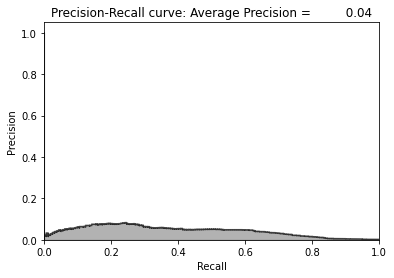

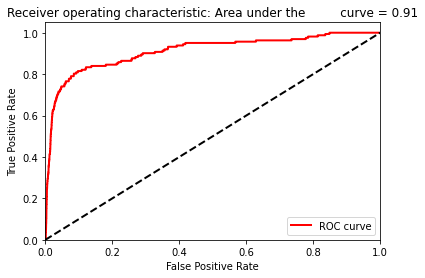

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0894 - accuracy: 0.8923 - val_loss: 0.0011 - val_accuracy: 0.9803
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 8.2316e-04 - accuracy: 0.9936 - val_loss: 6.8799e-05 - val_accuracy: 0.9962
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 7.8084e-04 - accuracy: 0.9928 - val_loss: 6.2056e-04 - val_accuracy: 0.9928
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.0262e-04 - accuracy: 0.9948 - val_loss: 1.4007e-06 - val_accuracy: 0.9994
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.9735e-04 - accuracy: 0.9940 - val_loss: 7.7346e-05 - val_accuracy: 0.9957
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.5701e-04 - accuracy: 0.9941 - val_loss: 5.8580e-04 - val_accuracy: 0.9876
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.9047e-04 - 

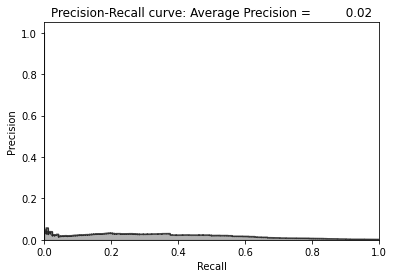

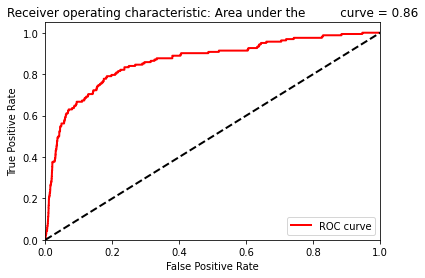

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0919 - accuracy: 0.8819 - val_loss: 0.0017 - val_accuracy: 0.9824
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0013 - accuracy: 0.9904 - val_loss: 4.5945e-06 - val_accuracy: 0.9989
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 8.0247e-04 - accuracy: 0.9932 - val_loss: 3.3648e-04 - val_accuracy: 0.9931
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 4.5409e-04 - accuracy: 0.9949 - val_loss: 1.0676e-06 - val_accuracy: 0.9995
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.2287e-04 - accuracy: 0.9931 - val_loss: 3.6697e-05 - val_accuracy: 0.9977
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.0818e-04 - accuracy: 0.9947 - val_loss: 5.4195e-04 - val_accuracy: 0.9901
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.5117e-04 - accu

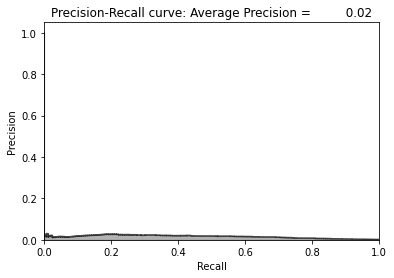

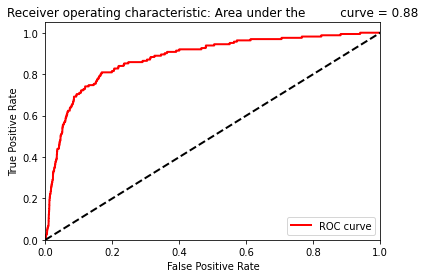

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0861 - accuracy: 0.8942 - val_loss: 0.0023 - val_accuracy: 0.9791
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0022 - accuracy: 0.9851 - val_loss: 5.3615e-04 - val_accuracy: 0.9903
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 8.7410e-04 - accuracy: 0.9927 - val_loss: 4.9912e-04 - val_accuracy: 0.9923
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 4.8419e-04 - accuracy: 0.9949 - val_loss: 2.7411e-05 - val_accuracy: 0.9989
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 7.8047e-04 - accuracy: 0.9933 - val_loss: 5.4631e-05 - val_accuracy: 0.9969
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.6201e-04 - accuracy: 0.9944 - val_loss: 6.4070e-04 - val_accuracy: 0.9891
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.5673e-04 - accu

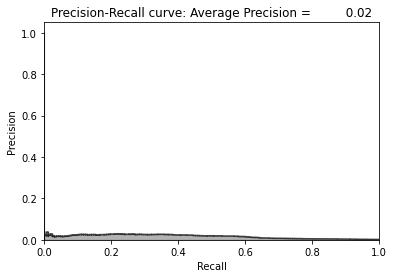

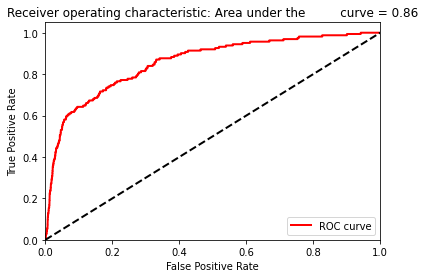

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0825 - accuracy: 0.8948 - val_loss: 0.0016 - val_accuracy: 0.9818
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 9.7989e-04 - accuracy: 0.9919 - val_loss: 4.9002e-04 - val_accuracy: 0.9912
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 9.5501e-04 - accuracy: 0.9931 - val_loss: 0.0013 - val_accuracy: 0.9871
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.0058e-04 - accuracy: 0.9946 - val_loss: 6.2309e-07 - val_accuracy: 0.9997
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.7601e-04 - accuracy: 0.9933 - val_loss: 6.6207e-05 - val_accuracy: 0.9969
Epoch 6/10
5964/5964 [==============================] - 18s 3ms/step - loss: 5.0397e-04 - accuracy: 0.9949 - val_loss: 8.4972e-04 - val_accuracy: 0.9885
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.4774e-04 - accu

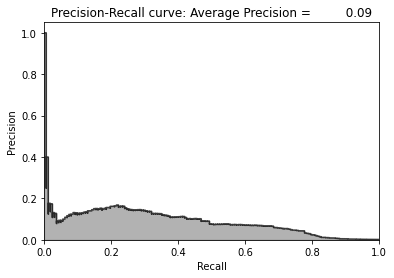

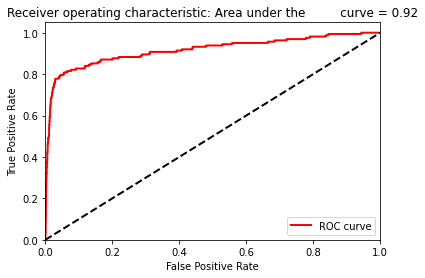

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0794 - accuracy: 0.8964 - val_loss: 0.0021 - val_accuracy: 0.9776
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0013 - accuracy: 0.9898 - val_loss: 6.1358e-04 - val_accuracy: 0.9896
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 9.7767e-04 - accuracy: 0.9932 - val_loss: 6.1797e-04 - val_accuracy: 0.9918
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.0395e-04 - accuracy: 0.9944 - val_loss: 7.6033e-06 - val_accuracy: 0.9991
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 6.3032e-04 - accuracy: 0.9933 - val_loss: 4.0042e-05 - val_accuracy: 0.9974
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 3.9754e-04 - accuracy: 0.9951 - val_loss: 0.0017 - val_accuracy: 0.9783
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 7.3597e-04 - accuracy

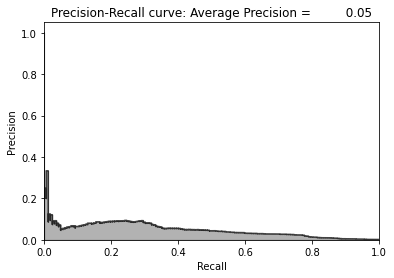

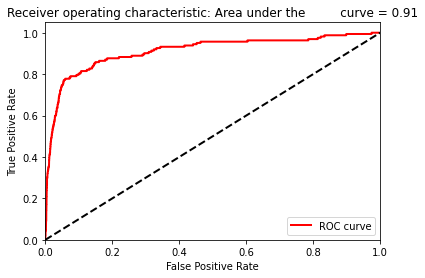

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0811 - accuracy: 0.8955 - val_loss: 0.0015 - val_accuracy: 0.9746
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 9.0204e-04 - accuracy: 0.9917 - val_loss: 1.8570e-04 - val_accuracy: 0.9939
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 8.1066e-04 - accuracy: 0.9932 - val_loss: 4.7163e-04 - val_accuracy: 0.9919
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.0902e-04 - accuracy: 0.9940 - val_loss: 1.8953e-06 - val_accuracy: 0.9995
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.6127e-04 - accuracy: 0.9929 - val_loss: 4.6170e-05 - val_accuracy: 0.9971
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 4.1662e-04 - accuracy: 0.9950 - val_loss: 0.0021 - val_accuracy: 0.9806
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 5.0322e-04 - accu

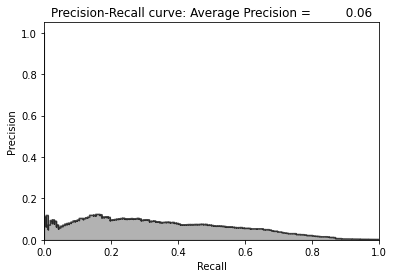

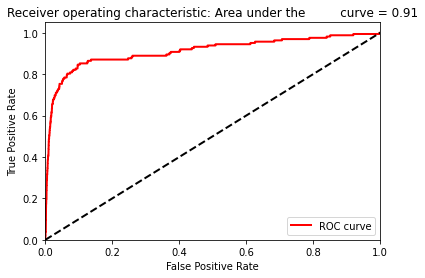

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0832 - accuracy: 0.8957 - val_loss: 0.0020 - val_accuracy: 0.9784
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0011 - accuracy: 0.9914 - val_loss: 4.2437e-05 - val_accuracy: 0.9974
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.5309e-04 - accuracy: 0.9937 - val_loss: 4.8043e-04 - val_accuracy: 0.9925
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.1415e-04 - accuracy: 0.9947 - val_loss: 4.0076e-06 - val_accuracy: 0.9990
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 6.3278e-04 - accuracy: 0.9936 - val_loss: 1.3429e-04 - val_accuracy: 0.9957
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 5.5588e-04 - accuracy: 0.9946 - val_loss: 7.6822e-04 - val_accuracy: 0.9874
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 4.3175e-04 - accu

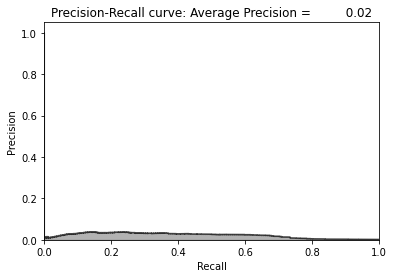

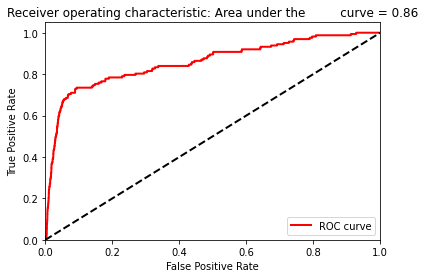

Mean average precision over 10 runs: 0.03524486532956536


[0.02, 0.0156, 0.0427, 0.0181, 0.0158, 0.0165, 0.0918, 0.0492, 0.0612, 0.0217]

In [22]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [23]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0352
Coefficient of variation over 10 runs: 0.692


[0.02, 0.0156, 0.0427, 0.0181, 0.0158, 0.0165, 0.0918, 0.0492, 0.0612, 0.0217]

# Model Two
## Two layer undercomplete autoencoder with linear activation
## 20 nodes in hidden layer

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.3463 - accuracy: 0.5856 - val_loss: 0.2780 - val_accuracy: 0.6435
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2810 - accuracy: 0.6406 - val_loss: 0.2753 - val_accuracy: 0.6338
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2789 - accuracy: 0.6467 - val_loss: 0.2740 - val_accuracy: 0.6413
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2773 - accuracy: 0.6484 - val_loss: 0.2744 - val_accuracy: 0.6533
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6512 - val_loss: 0.2732 - val_accuracy: 0.6609
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6627 - val_loss: 0.2735 - val_accuracy: 0.6584
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2765 - accuracy: 0.6646 - val_loss: 0.2736 - val_ac

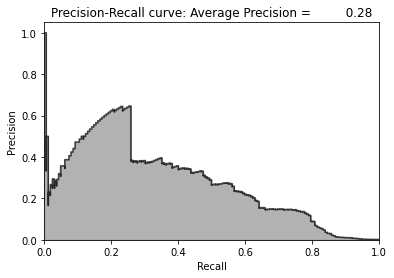

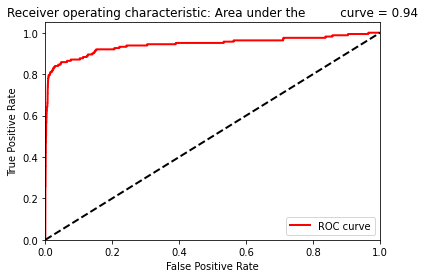

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.3446 - accuracy: 0.5553 - val_loss: 0.2778 - val_accuracy: 0.6169
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2805 - accuracy: 0.6240 - val_loss: 0.2752 - val_accuracy: 0.6392
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2784 - accuracy: 0.6416 - val_loss: 0.2740 - val_accuracy: 0.6431
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2775 - accuracy: 0.6455 - val_loss: 0.2746 - val_accuracy: 0.6387
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2769 - accuracy: 0.6510 - val_loss: 0.2733 - val_accuracy: 0.6491
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6473 - val_loss: 0.2738 - val_accuracy: 0.6531
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2766 - accuracy: 0.6542 - val_loss: 0.2741 - val_ac

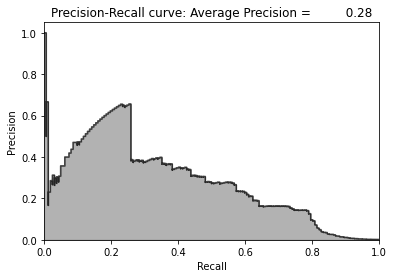

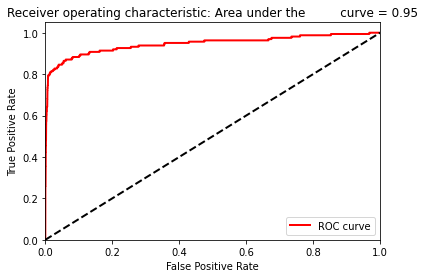

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.3459 - accuracy: 0.5622 - val_loss: 0.2791 - val_accuracy: 0.6320
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2820 - accuracy: 0.6455 - val_loss: 0.2757 - val_accuracy: 0.6553
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2793 - accuracy: 0.6699 - val_loss: 0.2743 - val_accuracy: 0.6696
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2778 - accuracy: 0.6634 - val_loss: 0.2745 - val_accuracy: 0.6668
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2772 - accuracy: 0.6645 - val_loss: 0.2736 - val_accuracy: 0.6672
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2769 - accuracy: 0.6584 - val_loss: 0.2739 - val_accuracy: 0.6647
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6632 - val_loss: 0.2742 - val_ac

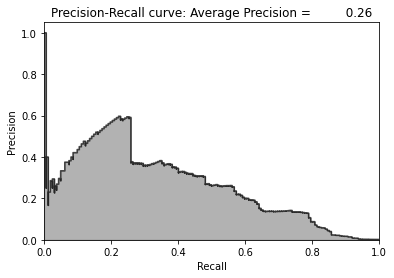

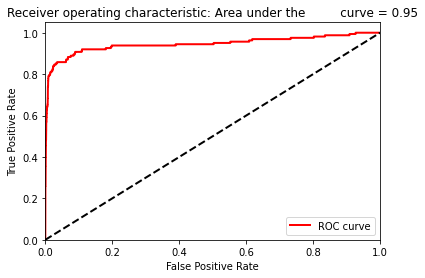

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.3435 - accuracy: 0.5435 - val_loss: 0.2784 - val_accuracy: 0.6037
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2812 - accuracy: 0.6119 - val_loss: 0.2756 - val_accuracy: 0.6261
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2790 - accuracy: 0.6360 - val_loss: 0.2741 - val_accuracy: 0.6378
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2775 - accuracy: 0.6483 - val_loss: 0.2744 - val_accuracy: 0.6394
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2769 - accuracy: 0.6373 - val_loss: 0.2733 - val_accuracy: 0.6414
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2768 - accuracy: 0.6374 - val_loss: 0.2740 - val_accuracy: 0.6414
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6357 - val_loss: 0.2743 - val_ac

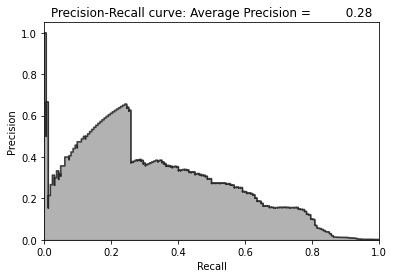

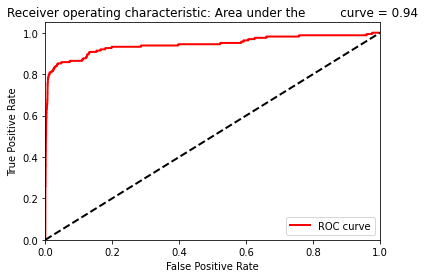

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.3503 - accuracy: 0.5366 - val_loss: 0.2780 - val_accuracy: 0.5982
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2809 - accuracy: 0.6103 - val_loss: 0.2753 - val_accuracy: 0.6117
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2785 - accuracy: 0.6218 - val_loss: 0.2743 - val_accuracy: 0.6300
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2779 - accuracy: 0.6443 - val_loss: 0.2748 - val_accuracy: 0.6354
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2771 - accuracy: 0.6352 - val_loss: 0.2736 - val_accuracy: 0.6428
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2769 - accuracy: 0.6410 - val_loss: 0.2740 - val_accuracy: 0.6416
Epoch 7/10
5964/5964 [==============================] - 19s 3ms/step - loss: 0.2769 - accuracy: 0.6421 - val_loss: 0.2742 - val_ac

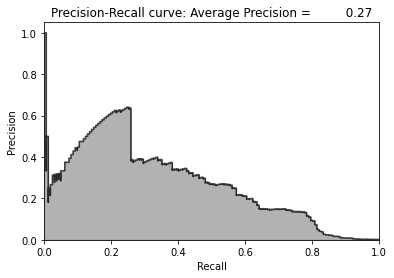

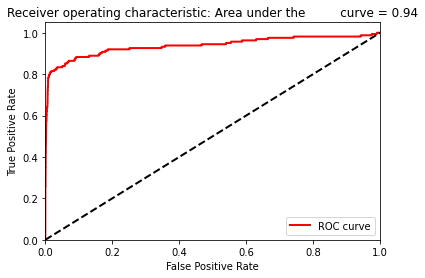

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.3502 - accuracy: 0.5810 - val_loss: 0.2791 - val_accuracy: 0.6367
Epoch 2/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.2810 - accuracy: 0.6382 - val_loss: 0.2761 - val_accuracy: 0.6496
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2791 - accuracy: 0.6630 - val_loss: 0.2749 - val_accuracy: 0.6517
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2780 - accuracy: 0.6599 - val_loss: 0.2748 - val_accuracy: 0.6539
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2770 - accuracy: 0.6634 - val_loss: 0.2735 - val_accuracy: 0.6597
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2768 - accuracy: 0.6595 - val_loss: 0.2741 - val_accuracy: 0.6692
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2767 - accuracy: 0.6734 - val_loss: 0.2742 - val_ac

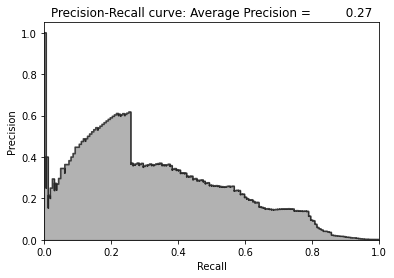

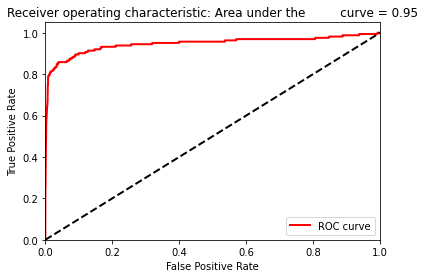

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.3451 - accuracy: 0.5345 - val_loss: 0.2788 - val_accuracy: 0.5749
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2812 - accuracy: 0.5758 - val_loss: 0.2759 - val_accuracy: 0.5731
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2793 - accuracy: 0.5819 - val_loss: 0.2746 - val_accuracy: 0.5731
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2779 - accuracy: 0.5869 - val_loss: 0.2749 - val_accuracy: 0.5876
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2774 - accuracy: 0.5973 - val_loss: 0.2738 - val_accuracy: 0.6063
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2773 - accuracy: 0.6055 - val_loss: 0.2744 - val_accuracy: 0.6095
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2772 - accuracy: 0.6163 - val_loss: 0.2753 - val_ac

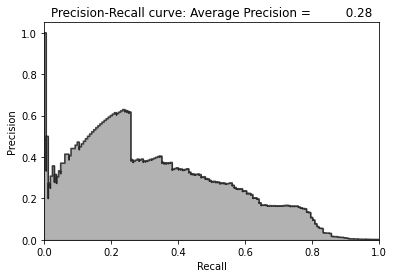

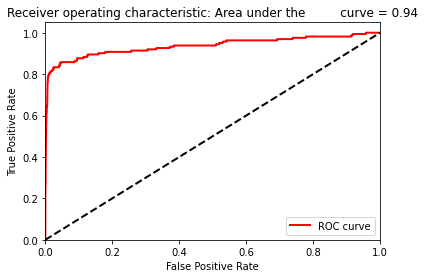

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.3611 - accuracy: 0.5434 - val_loss: 0.2783 - val_accuracy: 0.6143
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2810 - accuracy: 0.6061 - val_loss: 0.2753 - val_accuracy: 0.6202
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2787 - accuracy: 0.6240 - val_loss: 0.2740 - val_accuracy: 0.6374
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2775 - accuracy: 0.6589 - val_loss: 0.2743 - val_accuracy: 0.6483
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6513 - val_loss: 0.2730 - val_accuracy: 0.6524
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2767 - accuracy: 0.6527 - val_loss: 0.2736 - val_accuracy: 0.6477
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2767 - accuracy: 0.6584 - val_loss: 0.2736 - val_ac

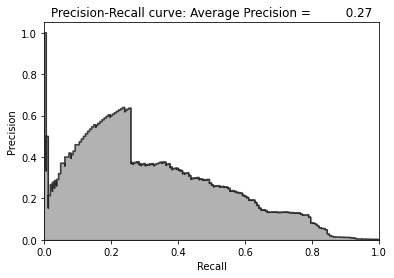

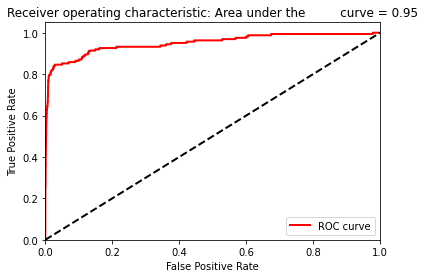

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.3389 - accuracy: 0.5604 - val_loss: 0.2786 - val_accuracy: 0.6051
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2814 - accuracy: 0.6186 - val_loss: 0.2761 - val_accuracy: 0.6221
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2794 - accuracy: 0.6452 - val_loss: 0.2745 - val_accuracy: 0.6381
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2779 - accuracy: 0.6427 - val_loss: 0.2746 - val_accuracy: 0.6432
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2769 - accuracy: 0.6479 - val_loss: 0.2734 - val_accuracy: 0.6472
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2766 - accuracy: 0.6466 - val_loss: 0.2739 - val_accuracy: 0.6498
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2766 - accuracy: 0.6552 - val_loss: 0.2737 - val_ac

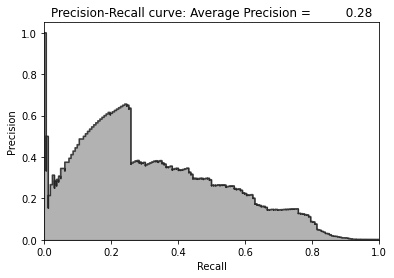

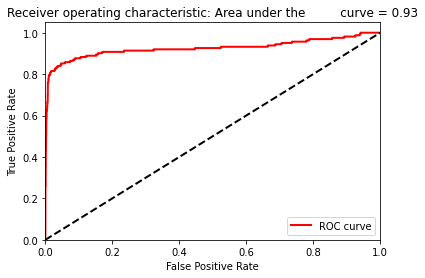

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.3493 - accuracy: 0.5359 - val_loss: 0.2801 - val_accuracy: 0.5858
Epoch 2/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.2823 - accuracy: 0.5968 - val_loss: 0.2768 - val_accuracy: 0.6055
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2801 - accuracy: 0.6209 - val_loss: 0.2752 - val_accuracy: 0.6374
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2782 - accuracy: 0.6527 - val_loss: 0.2750 - val_accuracy: 0.6591
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2774 - accuracy: 0.6662 - val_loss: 0.2737 - val_accuracy: 0.6645
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.2772 - accuracy: 0.6587 - val_loss: 0.2743 - val_accuracy: 0.6672
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.2770 - accuracy: 0.6638 - val_loss: 0.2742 - val_ac

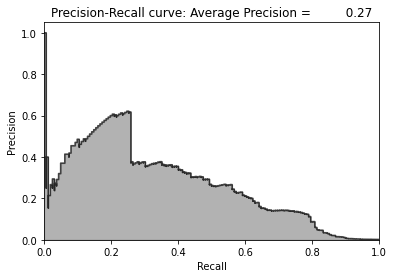

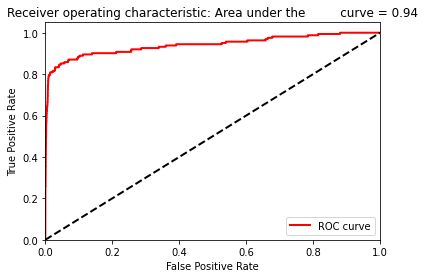

Mean average precision over 10 runs: 0.2752


[0.2799, 0.2837, 0.2649, 0.2822, 0.2744, 0.2674, 0.2816, 0.2711, 0.2755, 0.271]

In [25]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [26]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2752
Coefficient of variation over 10 runs: 0.0225


[0.2799, 0.2837, 0.2649, 0.2822, 0.2744, 0.2674, 0.2816, 0.2711, 0.2755, 0.271]

# Model Two v2
## Two layer undercomplete autoencoder with linear activation 
## With 27 nodes this time 

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1209 - accuracy: 0.8090 - val_loss: 0.0365 - val_accuracy: 0.8872
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0373 - accuracy: 0.9014 - val_loss: 0.0373 - val_accuracy: 0.9247
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0394 - accuracy: 0.9341 - val_loss: 0.0374 - val_accuracy: 0.9514
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0386 - accuracy: 0.9543 - val_loss: 0.0377 - val_accuracy: 0.9516
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0388 - accuracy: 0.9544 - val_loss: 0.0363 - val_accuracy: 0.9615
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0390 - accuracy: 0.9558 - val_loss: 0.0376 - val_accuracy: 0.9510
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0391 - accuracy: 0.9593 - val_loss: 0.0382 - val_ac

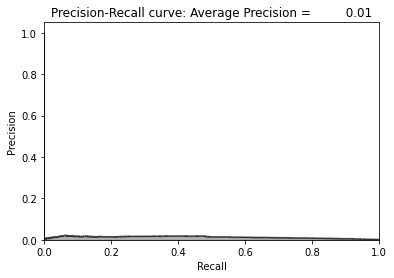

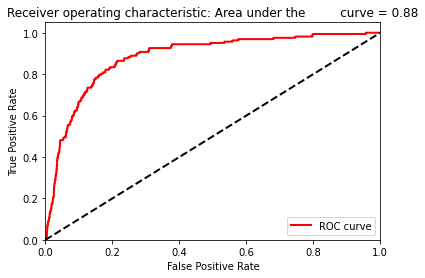

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1187 - accuracy: 0.8230 - val_loss: 0.0373 - val_accuracy: 0.9131
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0394 - accuracy: 0.9130 - val_loss: 0.0358 - val_accuracy: 0.9328
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0378 - accuracy: 0.9267 - val_loss: 0.0358 - val_accuracy: 0.9536
Epoch 4/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0378 - accuracy: 0.9502 - val_loss: 0.0368 - val_accuracy: 0.9379
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0368 - accuracy: 0.9475 - val_loss: 0.0356 - val_accuracy: 0.9412
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0395 - accuracy: 0.9464 - val_loss: 0.0362 - val_accuracy: 0.9445
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0394 - accuracy: 0.9516 - val_loss: 0.0375 - val_ac

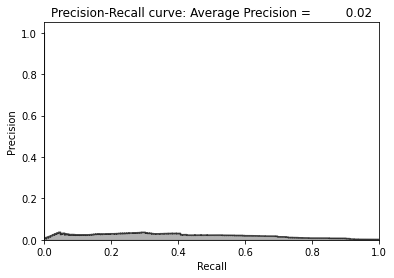

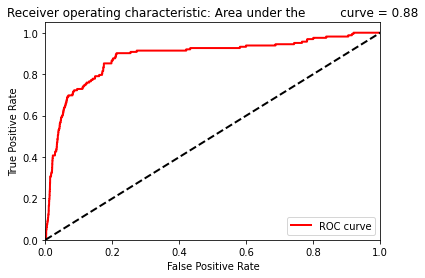

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1289 - accuracy: 0.8199 - val_loss: 0.0374 - val_accuracy: 0.9221
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0396 - accuracy: 0.9427 - val_loss: 0.0365 - val_accuracy: 0.9505
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0387 - accuracy: 0.9505 - val_loss: 0.0371 - val_accuracy: 0.9579
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0383 - accuracy: 0.9596 - val_loss: 0.0380 - val_accuracy: 0.9532
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0388 - accuracy: 0.9541 - val_loss: 0.0364 - val_accuracy: 0.9642
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0390 - accuracy: 0.9573 - val_loss: 0.0372 - val_accuracy: 0.9576
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0392 - accuracy: 0.9597 - val_loss: 0.0367 - val_ac

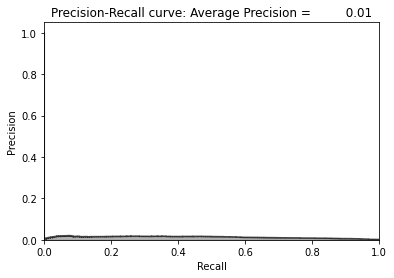

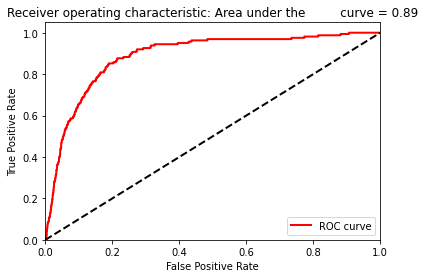

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1185 - accuracy: 0.8194 - val_loss: 0.0380 - val_accuracy: 0.9415
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0397 - accuracy: 0.9579 - val_loss: 0.0369 - val_accuracy: 0.9636
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0393 - accuracy: 0.9610 - val_loss: 0.0378 - val_accuracy: 0.9659
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0385 - accuracy: 0.9648 - val_loss: 0.0384 - val_accuracy: 0.9575
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0387 - accuracy: 0.9599 - val_loss: 0.0365 - val_accuracy: 0.9669
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0390 - accuracy: 0.9567 - val_loss: 0.0383 - val_accuracy: 0.9500
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0392 - accuracy: 0.9601 - val_loss: 0.0369 - val_ac

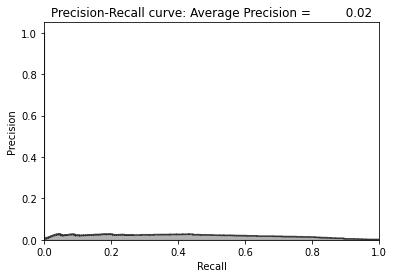

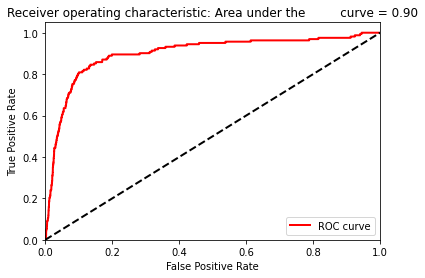

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1244 - accuracy: 0.8212 - val_loss: 0.0375 - val_accuracy: 0.9155
Epoch 2/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0400 - accuracy: 0.9380 - val_loss: 0.0369 - val_accuracy: 0.9474
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0391 - accuracy: 0.9513 - val_loss: 0.0375 - val_accuracy: 0.9534
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0386 - accuracy: 0.9609 - val_loss: 0.0381 - val_accuracy: 0.9586
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0387 - accuracy: 0.9593 - val_loss: 0.0365 - val_accuracy: 0.9662
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0392 - accuracy: 0.9561 - val_loss: 0.0373 - val_accuracy: 0.9535
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0392 - accuracy: 0.9594 - val_loss: 0.0371 - val_ac

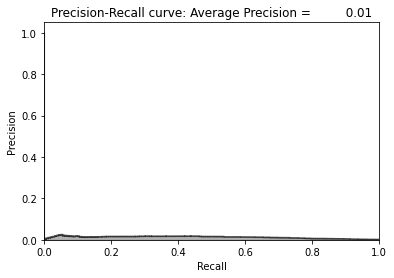

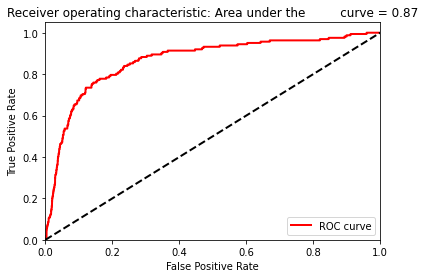

Epoch 1/10
5964/5964 [==============================] - 19s 3ms/step - loss: 0.1205 - accuracy: 0.8055 - val_loss: 0.0381 - val_accuracy: 0.8996
Epoch 2/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0395 - accuracy: 0.8993 - val_loss: 0.0362 - val_accuracy: 0.9169
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0388 - accuracy: 0.9242 - val_loss: 0.0363 - val_accuracy: 0.9368
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0388 - accuracy: 0.9408 - val_loss: 0.0373 - val_accuracy: 0.9443
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0383 - accuracy: 0.9490 - val_loss: 0.0361 - val_accuracy: 0.9582
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0391 - accuracy: 0.9550 - val_loss: 0.0372 - val_accuracy: 0.9520
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0393 - accuracy: 0.9595 - val_loss: 0.0372 - val_ac

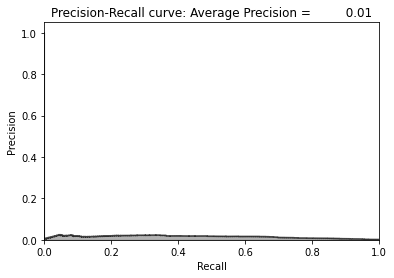

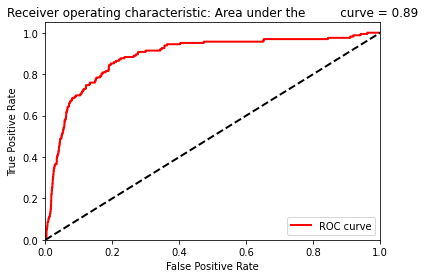

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1231 - accuracy: 0.8089 - val_loss: 0.0382 - val_accuracy: 0.8808
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0393 - accuracy: 0.8920 - val_loss: 0.0361 - val_accuracy: 0.9015
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0382 - accuracy: 0.9033 - val_loss: 0.0360 - val_accuracy: 0.9038
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0384 - accuracy: 0.9149 - val_loss: 0.0370 - val_accuracy: 0.9152
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0382 - accuracy: 0.9244 - val_loss: 0.0362 - val_accuracy: 0.9280
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0393 - accuracy: 0.9268 - val_loss: 0.0375 - val_accuracy: 0.9215
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0392 - accuracy: 0.9382 - val_loss: 0.0371 - val_ac

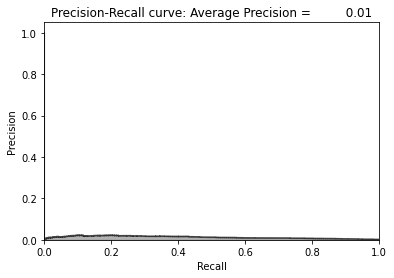

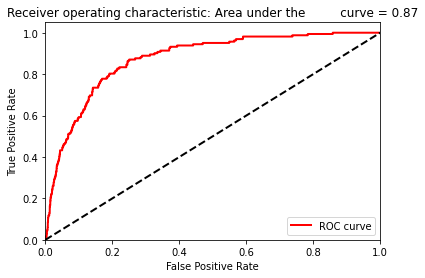

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1426 - accuracy: 0.7969 - val_loss: 0.0375 - val_accuracy: 0.9055
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0388 - accuracy: 0.9200 - val_loss: 0.0356 - val_accuracy: 0.9285
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0372 - accuracy: 0.9344 - val_loss: 0.0358 - val_accuracy: 0.9358
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0366 - accuracy: 0.9414 - val_loss: 0.0358 - val_accuracy: 0.9448
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0367 - accuracy: 0.9465 - val_loss: 0.0355 - val_accuracy: 0.9546
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0365 - accuracy: 0.9543 - val_loss: 0.0355 - val_accuracy: 0.9551
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0367 - accuracy: 0.9540 - val_loss: 0.0384 - val_ac

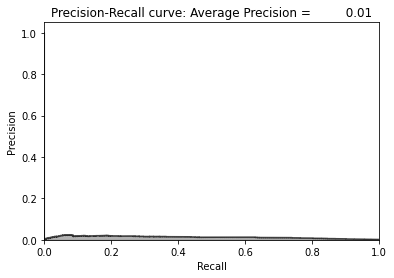

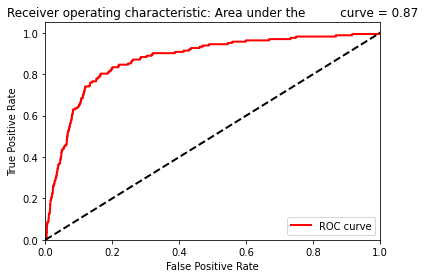

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.1135 - accuracy: 0.8220 - val_loss: 0.0369 - val_accuracy: 0.9214
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0400 - accuracy: 0.9444 - val_loss: 0.0366 - val_accuracy: 0.9577
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0390 - accuracy: 0.9560 - val_loss: 0.0380 - val_accuracy: 0.9659
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0383 - accuracy: 0.9653 - val_loss: 0.0379 - val_accuracy: 0.9620
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0387 - accuracy: 0.9655 - val_loss: 0.0365 - val_accuracy: 0.9695
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0393 - accuracy: 0.9597 - val_loss: 0.0370 - val_accuracy: 0.9597
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0390 - accuracy: 0.9635 - val_loss: 0.0379 - val_ac

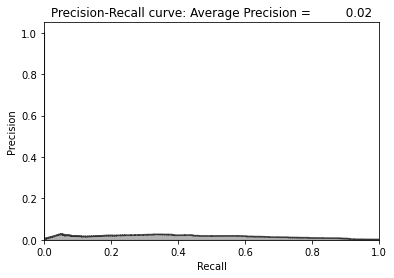

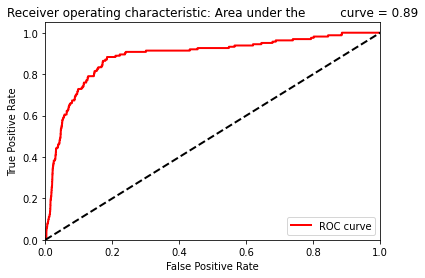

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1235 - accuracy: 0.8191 - val_loss: 0.0374 - val_accuracy: 0.9069
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0388 - accuracy: 0.9063 - val_loss: 0.0358 - val_accuracy: 0.9077
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0373 - accuracy: 0.9152 - val_loss: 0.0352 - val_accuracy: 0.9173
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0367 - accuracy: 0.9295 - val_loss: 0.0355 - val_accuracy: 0.9140
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0361 - accuracy: 0.9259 - val_loss: 0.0343 - val_accuracy: 0.9457
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.0360 - accuracy: 0.9443 - val_loss: 0.0354 - val_accuracy: 0.9138
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0361 - accuracy: 0.9423 - val_loss: 0.0373 - val_ac

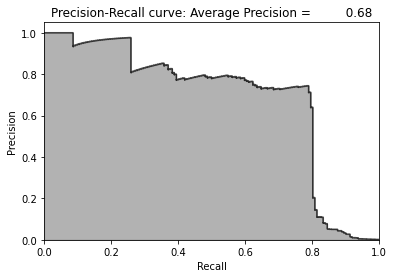

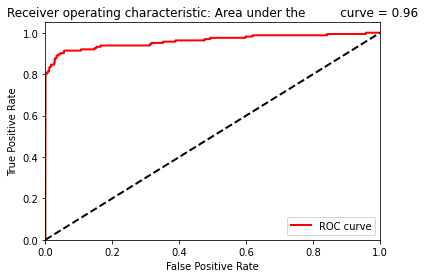

Mean average precision over 10 runs: 0.0819


[0.0128, 0.02, 0.0129, 0.0191, 0.0129, 0.0149, 0.0126, 0.0128, 0.0164, 0.6844]

In [28]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [29]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0819
Coefficient of variation over 10 runs: 2.4533


[0.0128, 0.02, 0.0129, 0.0191, 0.0129, 0.0149, 0.0126, 0.0128, 0.0164, 0.6844]

# Model Three
## Three layer undercomplete autoencoder with linear activation.
## With 28 and 27 nodes in the two hidden layers, respectively

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1276 - accuracy: 0.7977 - val_loss: 0.0369 - val_accuracy: 0.9341
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0408 - accuracy: 0.9467 - val_loss: 0.0366 - val_accuracy: 0.9531
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0396 - accuracy: 0.9555 - val_loss: 0.0393 - val_accuracy: 0.9610
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0388 - accuracy: 0.9621 - val_loss: 0.0384 - val_accuracy: 0.9571
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0394 - accuracy: 0.9602 - val_loss: 0.0363 - val_accuracy: 0.9685
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0397 - accuracy: 0.9592 - val_loss: 0.0390 - val_accuracy: 0.9502
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0396 - accuracy: 0.9586 - val_loss: 0.0373 - val_ac

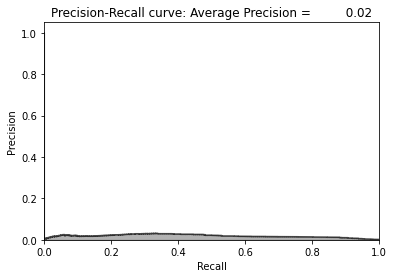

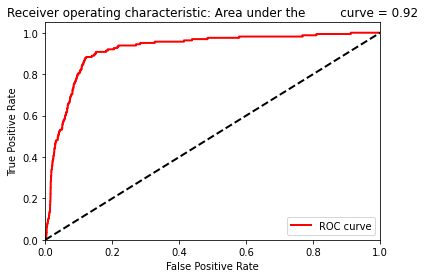

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1174 - accuracy: 0.8160 - val_loss: 0.0388 - val_accuracy: 0.9175
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0408 - accuracy: 0.9453 - val_loss: 0.0366 - val_accuracy: 0.9533
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0396 - accuracy: 0.9548 - val_loss: 0.0395 - val_accuracy: 0.9562
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0386 - accuracy: 0.9619 - val_loss: 0.0386 - val_accuracy: 0.9533
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0393 - accuracy: 0.9561 - val_loss: 0.0364 - val_accuracy: 0.9655
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0397 - accuracy: 0.9580 - val_loss: 0.0376 - val_accuracy: 0.9530
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0396 - accuracy: 0.9597 - val_loss: 0.0383 - val_ac

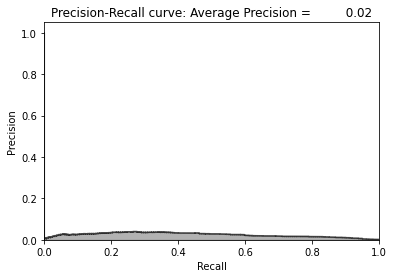

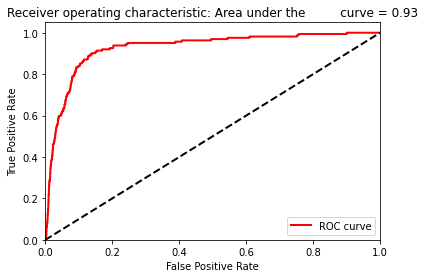

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1214 - accuracy: 0.7900 - val_loss: 0.0420 - val_accuracy: 0.8860
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0407 - accuracy: 0.9001 - val_loss: 0.0365 - val_accuracy: 0.9158
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0394 - accuracy: 0.9241 - val_loss: 0.0406 - val_accuracy: 0.9272
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0385 - accuracy: 0.9425 - val_loss: 0.0374 - val_accuracy: 0.9426
Epoch 5/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0395 - accuracy: 0.9462 - val_loss: 0.0358 - val_accuracy: 0.9541
Epoch 6/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0392 - accuracy: 0.9495 - val_loss: 0.0399 - val_accuracy: 0.9402
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0396 - accuracy: 0.9550 - val_loss: 0.0387 - val_ac

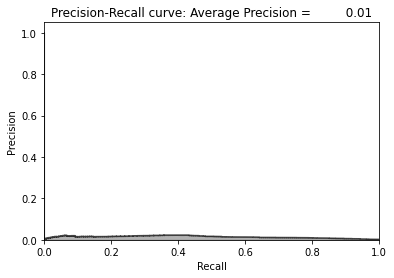

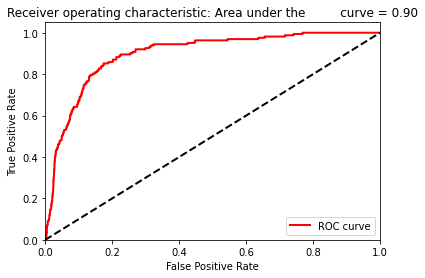

Epoch 1/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.1250 - accuracy: 0.7990 - val_loss: 0.0419 - val_accuracy: 0.9011
Epoch 2/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0403 - accuracy: 0.9120 - val_loss: 0.0360 - val_accuracy: 0.9130
Epoch 3/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0388 - accuracy: 0.9167 - val_loss: 0.0373 - val_accuracy: 0.9132
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0394 - accuracy: 0.9260 - val_loss: 0.0377 - val_accuracy: 0.9314
Epoch 5/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0391 - accuracy: 0.9361 - val_loss: 0.0356 - val_accuracy: 0.9473
Epoch 6/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0393 - accuracy: 0.9462 - val_loss: 0.0370 - val_accuracy: 0.9432
Epoch 7/10
5964/5964 [==============================] - 17s 3ms/step - loss: 0.0395 - accuracy: 0.9508 - val_loss: 0.0378 - val_ac

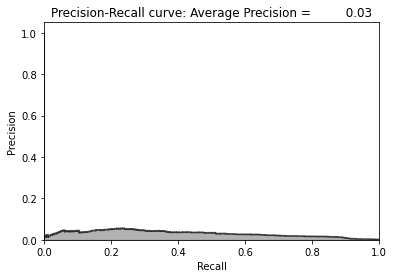

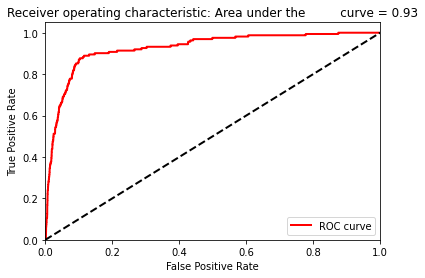

Epoch 1/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.1088 - accuracy: 0.8202 - val_loss: 0.0383 - val_accuracy: 0.9031
Epoch 2/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0396 - accuracy: 0.9252 - val_loss: 0.0365 - val_accuracy: 0.9249
Epoch 3/10
1130/5964 [====>.........................] - ETA: 9s - loss: 0.0506 - accuracy: 0.9199

KeyboardInterrupt: 

In [31]:
# 10 runs - We will capture mean of average precision
tf.random.set_seed(42)
np.random.seed(42)
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Four
## Four layer undercomplete autoencoder with ReLu activation
## 29 -> 27 -> 22 -> 27 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Five
## Two layer overcomplete autoencoder with linear activation
## 29 -> 40 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Six
## Two layer overcomplete autoencoder with linear activation and dropout
## 29 -> 40 -> 29
## Dropout percentage: 10%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Seven
## Two layer sparse overcomplete autoencoder with linear activation
## 29 -> 40 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Eight
## Two layer sparse overcomplete autoencoder with linear activation and dropout
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Nine
## Two layer denoising undercomplete autoencoder with linear activation
## 29 -> 27 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Ten
## Two layer denoising overcomplete autoencoder with linear activation
## And sparsity regularizer and dropout  
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Model Eleven
## Two layer denoising overcomplete autoencoder with ReLU activation
## And sparsity regularizer and dropout  
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

# Conclusion

In [ ]:
import datetime as dt
print("Completed: ", dt.datetime.now())